# Raw Data Modeling

In [254]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set()

# import custom dependencies
from ADNI_utilities import define_terms, describe_meta_data, paths_with_ext, append_meta_cols
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

**Import Data**

In [255]:
# read in per patient data
pat_df = pd.read_csv("../data/Per_Patient/patient_firstidx_merge.csv")
pat_df.shape

(3652, 197)

## Impute the Data



Before imputing the data, we should start by characterizing the missingness of the data and throwing out any features with too much missingness.

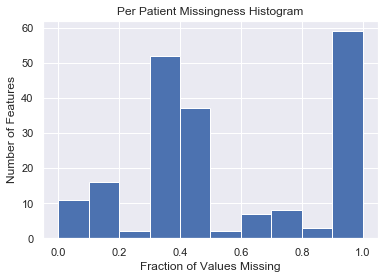

In [256]:
# plot histogram of missing values
pct_missing = np.sum(pat_df.values==-1,0)/pat_df.shape[0]
plt.hist(pct_missing)
plt.xlabel("Fraction of Values Missing")
plt.ylabel("Number of Features")
plt.title("Per Patient Missingness Histogram");

Given the large number of features with all or nearly all of the data missing, it makes sense to set a cutoff of 80% missing.

In [257]:
# throw away columns with high missingness
drop_cols = pat_df.columns[pct_missing>0.8]
pat_df = pat_df.drop(columns=drop_cols, axis=1)

# throw away any row with a missing value in the diagnosis
no_dx = pat_df.DX_FINAL.values == -1

# return df with rows dropped
pat_df = pat_df.drop(index=pat_df.loc[no_dx].index)

In [258]:
pat_df.shape

(2025, 135)

After filtering the data this way, we are left with a data set with approximately 2,000 patients and 130 features.

In [259]:
# compute mean of each numeric column with missing values
meta_cols = ["RID"]
pat_df = pat_df.drop(columns=meta_cols, axis=1)

col_means = pat_df.apply(np.nanmean)
is_missing = pat_df.apply(lambda x: x== -1).values

#index each column and replace with column mode (categorical) or column mean (continuous)
for i, col in enumerate(pred_df.columns):
    if type(pat_df[col].values[0]) is np.int64:
        replacement = stats.mode(pat_df.loc[~is_missing[:,i],col])[0][0]
    elif pred_df[col].dtype is float:
        replacement = np.nanmean(pat_df.loc[~is_missing[:,i],col])
        
    pat_df.loc[is_missing[:,i],col] = replacement

We can check the number of missing values in the data set to see if any remain.

In [260]:
pat_df.apply(lambda x: x== -1).values.astype(int).sum()

0

## Modeling

Let's try to model the data with a decision tree model. We'll start by splitting the data.

In [261]:
# one-hot encode categorical variables
# define columns with possible response variables (i.e. trivial predictors)
resp_cols = ["DX_BASE","DX_FINAL","DXCOMB","DX_CHANGE"]
cat_cols = pat_df.columns[pat_df.dtypes == np.int64]
cat_cols = list(set(cat_cols) - set(resp_cols))

pat_df = pd.get_dummies(pat_df, columns=cat_cols)

In [274]:
# split data into train and test sets
train_df, test_df = train_test_split(pat_df, test_size=0.2)
x_train = train_df.drop(columns=resp_cols, axis=1)
y_train = train_df.DX_FINAL
x_test = test_df.drop(columns=resp_cols, axis=1)
y_test = test_df.DX_FINAL

Max Train Score at depth = 3
mean accuracy (test): 0.615


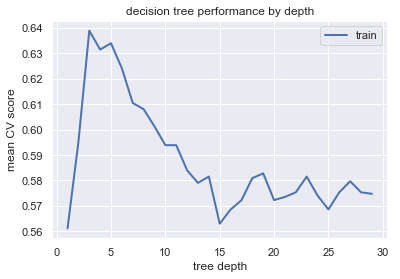

In [275]:
#define depths to test
depths = np.arange(1,30,1)
avg_train_score = np.empty(depths.shape, dtype=float)
avg_test_score = np.empty(depths.shape, dtype=float)

# fit decision tree at each depth and record accuracy
for i, depth in enumerate(depths):
    clf = DecisionTreeClassifier(criterion="gini", max_depth=depth).fit(x_train,y_train)
    avg_train_score[i] = cross_val_score(clf, x_train.values, y_train.values, cv=5).mean()
    
plt.plot(depths, avg_train_score, c='b', lw=2, label="train")
ax = plt.gca()
ax.set_xlabel("tree depth")
ax.set_ylabel("mean CV score")
ax.legend()
ax.set_title("decision tree performance by depth");

# train clf at best depth and report accuracy
best_depth = depths[np.argmax(avg_train_score)]
best_clf = DecisionTreeClassifier(criterion="gini", max_depth=best_depth).fit(x_train.values,y_train.values)
print("Max Train Score at depth = %i" % best_depth)
print("mean accuracy (test): {0:.3f}".format(cross_val_score(best_clf, x_test.values, y_test.values, cv=10).mean()))


In [602]:
tree = DecisionTreeClassifier(criterion="gini", max_depth=3).fit(x_train,y_train)
print("mean accuracy (train): {0:.3f}".format(cross_val_score(tree, x_train.values, y_train.values, cv=10).mean()))
print("mean accuracy (train): {0:.3f}".format(cross_val_score(tree, x_test.values, y_test.values, cv=10).mean()))

mean accuracy (train): 0.858
mean accuracy (train): 0.882


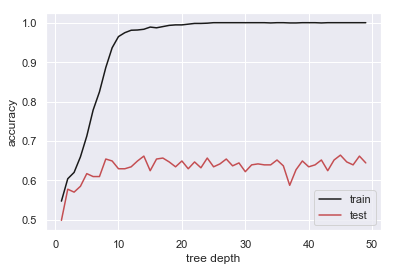

In [276]:
# define and fit logistic regression model
from sklearn.ensemble import RandomForestClassifier
depths = np.arange(1,50,1)
train_acc = np.empty(depths.shape[0])
test_acc = np.empty(depths.shape[0])

for i, depth in enumerate(depths):
    
    # train temp model
    rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=depth)
    rfc = rfc.fit(x_train.values, y_train.values)
    train_acc[i] = rfc.score(x_train.values, y_train.values)
    test_acc[i] = rfc.score(x_test.values, y_test.values)
    
plt.plot(depths, train_acc, color='k', label="train")
plt.plot(depths, test_acc, color='r', label="test");
plt.xlabel("tree depth")
plt.ylabel("accuracy")
plt.legend();

In [277]:
# define tree model
rand_forest = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=6)
rand_forest = rand_forest.fit(x_train.values, y_train.values)

In [278]:
# report test and train accuracy
print("Train accuracy = {0:.3f}".format(rand_forest.score(x_train.values, y_train.values)))
print("Test accuracy = {0:.3f}".format(rand_forest.score(x_test.values, y_test.values)))

Train accuracy = 0.783
Test accuracy = 0.625


In [279]:
# lets compare it to a bad model
np.histogram(pat_df.DX_FINAL.values, bins=[1,2,3,4])[0]/pat_df.shape[0]

array([0.35802469, 0.32938272, 0.31259259])

In [280]:
# This code is adapted from
# http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
def show_tree_structure(clf):
    tree = clf.tree_

    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print(f"The binary tree structure has {n_nodes} nodes:\n")
    
    for i in range(n_nodes):
        indent = node_depth[i] * "  "
        if is_leaves[i]:
            prediction = clf.classes_[np.argmax(tree.value[i])]
            print(f"{indent}node {i}: predict class {prediction}")
        else:
            print("{}node {}: if X[:, {}] <= {:.3f} then go to node {}, else go to node {}".format(
                indent, i, feature[i], threshold[i], children_left[i], children_right[i]))

In [281]:
show_tree_structure(best_clf)

The binary tree structure has 15 nodes:

node 0: if X[:, 50] <= 26.500 then go to node 1, else go to node 8
  node 1: if X[:, 50] <= 23.500 then go to node 2, else go to node 5
    node 2: if X[:, 31] <= 15.500 then go to node 3, else go to node 4
      node 3: predict class 3
      node 4: predict class 3
    node 5: if X[:, 2] <= 180.500 then go to node 6, else go to node 7
      node 6: predict class 3
      node 7: predict class 2
  node 8: if X[:, 19] <= 51.500 then go to node 9, else go to node 12
    node 9: if X[:, 195] <= 0.500 then go to node 10, else go to node 11
      node 10: predict class 2
      node 11: predict class 1
    node 12: if X[:, 5] <= 0.500 then go to node 13, else go to node 14
      node 13: predict class 1
      node 14: predict class 2


In [282]:
# print columns in order of importance
splits = [50,19,2,31,5,195]
x_train.columns[splits]

Index(['MMSCORE', 'RCT19', 'ABETA', 'RCT5', 'GDTOTAL', 'DXMPTR3_1'], dtype='object')